In [14]:
import talib
import pandas as pd
import numpy as np
from dataProcess.DataClean import CDataClean
import matplotlib.pyplot as plt

In [2]:
# CDC = CDataClean(r'C:\Users\Administrator\Desktop\pythonHistoricalTesting\data\USA30.IDXUSD_Candlestick_1_D_BID_15.04.2018-20.11.2020.csv')

# df = CDC.TranslateCsvToDF_NotDropDuplicates()
# df = df.loc[df.Volume > 1e-6].reset_index(drop = True)


In [15]:
CDC = CDataClean('/Users/Administrator/Desktop/pythonHistoricalTesting/data/USA30.IDXUSD_Candlestick_15_M_BID_15.04.2018-20.11.2020.csv')
df = CDC.TranslateCsvToDF_NotDropDuplicates()

def NewOpenBar(df):
    
    summer = ((df.GMT < '2018-11-04 02:00:00') | \
             ((df.GMT >= '2019-03-10 02:00:00') & (df.GMT < '2019-11-03 02:00:00')) | \
             ((df.GMT >= '2020-03-08 02:00:00') & (df.GMT < '2020-11-01 02:00:00'))).values
    
    df['SW'] = summer
    df['DayOfWeek'] = df.GMT.dt.dayofweek
    
    isOpenBar = []
    
    for gmt, sw, dow in zip(df.GMT, df.SW, df.DayOfWeek):
        
        if((sw == 1 and gmt.strftime('%H:%M:%S') == '13:30:00') or (sw == 0 and gmt.strftime('%H:%M:%S') == '14:30:00')):
            
            if(dow != 5 and dow != 6):
            
                isOpenBar.append('Open')
            
            else:
                
                isOpenBar.append(' ')
        
        else:
            
            isOpenBar.append(' ')
    
    df['IsOpenBar'] = isOpenBar
    
    return df

df = NewOpenBar(df)

newOpenBarList = df.loc[df.IsOpenBar == 'Open'].index.tolist()

rowInfo = []

for s, e in zip(newOpenBarList[:-1], newOpenBarList[1:]):

    data = df.loc[s:(e-1)]
    
    GMT = data.iloc[0].GMT
    Open = data.iloc[0].Open
    High = np.max(data.High)
    Low = np.min(data.Low)
    Close = data.iloc[-1].Close
    Volume = np.sum(data.Volume)

    rowInfo.append([GMT, Open, High, Low, Close, Volume])

df_D = pd.DataFrame(data=rowInfo, columns=['GMT','Open','High','Low','Close','Volume'])

#df = df_D.loc[df_D.Volume > 1e-6].reset_index(drop=True)

df = df_D.loc[df_D.Volume > 1e-6].reset_index(drop=True)

In [16]:
df['Range'] = df.High - df.Low
Date = []
for i in range(df.GMT.size):
    Date.append(df.loc[i].GMT.strftime('%Y-%m-%d'))
df['Date'] = Date

In [17]:
df

,GMT,Open,High,Low,Close,Volume,Range,Date
0,2018-04-16 13:30:00,24525.070,24829.570,24485.169,24824.069,2.875840e+08,344.401,2018-04-16
1,2018-04-17 13:30:00,24824.069,24860.169,24724.970,24793.569,3.087561e+08,135.199,2018-04-17
2,2018-04-18 13:30:00,24793.569,24827.669,24656.069,24692.570,2.217600e+08,171.600,2018-04-18
3,2018-04-19 13:30:00,24693.069,24757.670,24550.670,24658.070,3.405954e+08,207.000,2018-04-19
4,2018-04-20 13:30:00,24658.570,24679.170,24373.670,24513.570,3.986900e+08,305.500,2018-04-20
...,...,...,...,...,...,...,...,...
674,2020-11-13 14:30:00,29264.057,30072.799,29210.699,29897.049,2.695476e+07,862.100,2020-11-13
675,2020-11-16 14:30:00,29897.087,29981.279,29645.559,29696.019,2.423856e+07,335.720,2020-11-16
676,2020-11-17 14:30:00,29696.299,29957.297,29519.249,29872.799,2.810704e+07,438.048,2020-11-17
677,2020-11-18 14:30:00,29875.599,29929.999,29242.499,29360.029,2.910061e+07,687.500,2020-11-18


In [43]:
def CalcTargetBoundary(counts, bin_edges, targetPersentage=0.7):
    
    targetSum = np.sum(counts) * targetPersentage
    startPosition = np.argmax(counts)
    currentSum = np.max(counts)
    
    leftIdx = startPosition - 1
    rightIdx = startPosition + 1

    while currentSum < targetSum:

        if(leftIdx >= 0 and rightIdx >= 0):
            
            #print('leftIdx: '+ str(leftIdx))
            #print('rightIdx: '+ str(rightIdx))

            if(counts[leftIdx] > counts[rightIdx]):
                currentSum += counts[leftIdx]
                leftIdx -= 1

            else:
                currentSum += counts[rightIdx]
                rightIdx += 1

        if(leftIdx<0):
            currentSum += counts[rightIdx]
            rightIdx += 1

        if(rightIdx<0):
            currentSum += counts[leftIdx]
            leftIdx += 1 
    
    return ((bin_edges[leftIdx], bin_edges[rightIdx+1]))

In [8]:
#df.loc[df.Date == "2020-01-01"]#2020的index序列536 596 656 716 776   753 813

,GMT,Open,High,Low,Close,Volume,Range,Date
447,2020-01-01 14:30:00,28567.7,28708.1,28557.29,28642.87,3.977712e+06,150.81,2020-01-01


In [19]:
#绘制ratio的时间序列图和频率分布直方图
def Pic4Ratio(df,num):
    '''
    这里的df为经过DataProcess4SMA1处理的dataframe
    num为图片保存命名的时候使用，为了标识这是哪个时间段的图，比如2020年第2季度
    '''
    #绘制时间序列图
    plt.figure(figsize = (100,8))
    plt.plot(df.Date,df.Ratio)
    plt.title("使用SMA1的Ratio时间序列图")
    plt.savefig('./SMA1_ratio_timeseries_{}.jpg'.format(num))
    
    
    #绘制频率分布直方图
    plt.figure(figsize = (20,8))
    plt.rcParams["font.sans-serif"]='SimHei'
    plt.rcParams['axes.unicode_minus']=False
    %config InlineBackend.figure_format='svg'

    plt.hist(x=df.Ratio,bins=30,color="steelblue",edgecolor="black")
    plt.xlabel("Ratio")
    plt.ylabel("频数")
    plt.title("使用SMA1的Ratio频率分布直方图")
    plt.savefig('./SMA1_ratio_hist_{}.jpg'.format(num))


In [20]:
def Pic4Zscore(df,num):
    '''
    这里的df为经过DataProcess4SMA1处理的dataframe
    num为图片保存命名的时候使用，为了标识这是哪个时间段的图，比如2020年第2季度
    '''
    #绘制时间序列图，标注了相对于前一天是涨还是跌，并且在y轴上画出参考线
    plt.figure(figsize = (140,8))#################
    plt.plot(df.Date,df["Z-score"])
    plt.xticks(rotation=90)  
    plt.axhline(y=-1,ls=":",c="green")#添加水平直线
    plt.axhline(y=-0.5,ls=":",c="green")#添加水平直线
    plt.axhline(y=0,ls=":",c="green")#添加水平直线
    plt.axhline(y=0.5,ls=":",c="green")#添加水平直线
    plt.axhline(y=1,ls=":",c="green")#添加水平直线
    plt.axhline(y=2,ls=":",c="green")#添加水平直线
    plt.axhline(y=3,ls=":",c="green")#添加水平直线
    plt.axhline(y=4,ls=":",c="green")#添加水平直线
    
    plt.scatter(df.loc[df["flag"] == 1].Date,df.loc[df["flag"] == 1]["Z-score"],color = 'green',label = 'up')
    plt.scatter(df.loc[df["flag"] == 0].Date,df.loc[df["flag"] == 0]["Z-score"],color = 'red',label = 'down')
    
    plt.title("使用SMA1的Z-score时间序列图")
    plt.savefig('./SMA1_zscore_timeseries_{}.jpg'.format(num))
     
    
    #绘制频率分布直方图
    plt.figure(figsize = (20,8))
    plt.rcParams["font.sans-serif"]='SimHei'
    plt.rcParams['axes.unicode_minus']=False
    %config InlineBackend.figure_format='svg'
    plt.hist(x=df["Z-score"],bins=30,color="steelblue",edgecolor="black")
    plt.xlabel("Z-score")
    plt.ylabel("频数")
    plt.title("Z-score的频率分布直方图 SMA1")
    plt.savefig('./SMA1_zscore_hist_{}.jpg'.format(num))

In [32]:
def drawOutlierLocation(df,sigma):
    '''
    这里的df要是全序列的未剔除异常值的,而且已经去除了前60个
    '''
    
    counts, bin_edges = np.histogram(df["Z-score"].values.tolist(), bins=100)#注意zscore的前几个数是有问题的，切片时注意
    if sigma == 1:
        low, high = CalcTargetBoundary(counts, bin_edges, 0.6826)[0],CalcTargetBoundary(counts, bin_edges, 0.6826)[1]
        del_outlier = [i if (i >= low) & (i <= high) else 8 for i in df["Z-score"].values.tolist()]
        
        
    elif sigma == 2:
        low, high = CalcTargetBoundary(counts, bin_edges, 0.9545)[0],CalcTargetBoundary(counts, bin_edges, 0.9545)[1]
        del_outlier = [i if (i >= low) & (i <= high) else 8 for i in df["Z-score"].values.tolist()]
    else:
        low, high = CalcTargetBoundary(counts, bin_edges, 0.9973)[0],CalcTargetBoundary(counts, bin_edges, 0.9973)[1]
        del_outlier = [i if (i >= low) & (i <= high) else 8 for i in df["Z-score"].values.tolist()]
    
    #一倍标准差的范围
    df["del_outlier"] = del_outlier
    plt.figure(figsize = (100,8))
    plt.plot(df.Date,df.del_outlier)
    plt.xticks(rotation=90)
    plt.title("SMA1标出了outlier的Z-score时间序列图")
    plt.savefig('./SMA1_zscore_show_{}_outlier.jpg'.format(sigma))
    
    

In [22]:
def DataProcess4SMA1(df,a,b,sigma = 0):
    '''
    这个函数用于返回一个处理完的dataframe，新增Ratio,zscore和flag
    df为cam处理完的raw data
    a和b分别为需要研究的时间区间
    sigma表示去掉的异常值的标准 0：不去除 1：去除一倍标准差 2：去除两倍标准差
    默认滚20天为周期
    '''
    
    Ratio = [1]#先填充一个1
    
    for i in range(1,len(df.Range)):
        temp = df.Range[i]/df.Range[i - 1]
        Ratio.append(temp)
    df1 = df.copy()
    df1["Ratio"] = Ratio
    
    #判断当天是涨还是跌
    today_up_or_down_temp = (df1["Close"] - df1["Open"]).values.tolist()
    today_up_or_down = [1 if i >= 0 else 0 for i in today_up_or_down_temp]
    df1["today_up_or_down"] = today_up_or_down
        
    
    
    zscore = [1]*60
    for i in range(60,len(Ratio)):#剔除前60个值计算
        ratio_mean_sub = np.array(Ratio[(i-20):(i+1)]).mean()#向前滚20
        ratio_std_sub = np.array(Ratio[(i-20):(i+1)]).std()
        zscore_sub = (Ratio[i] - ratio_mean_sub)/ratio_std_sub
        zscore.append(zscore_sub)    
    df1['Z-score'] = zscore
    df1['Z-score_tomorrow'] = zscore[1:] + [1]
    
    #添加一个flag列
    flag = [0]   
    for i in range(len(zscore)-1):
        if abs(df1.High[i + 1] - df1.Close[i]) >= abs(df1.Low[i + 1] - df1.Close[i]):
            flag_temp = 1
        else:
            flag_temp = 0
        flag.append(flag_temp)
    
    df1["flag"] = flag
    df1["flag_tomorrow"] = flag[1:] + [1]
    
    counts, bin_edges = np.histogram(zscore[60:], bins=100)#注意zscore的前几个数是有问题的，切片时注意
    
    if sigma == 0:
        return df1  
    
    #如果需要去除outlier的话需执行下面的代码，且zscore要重新计算
    
    else:#sigma不为0的时候执行，也就是需要剔除标准差之外的来作图
        if sigma == 1:
            low, high = CalcTargetBoundary(counts, bin_edges, 0.6826)[0],CalcTargetBoundary(counts, bin_edges, 0.6826)[1]#一倍标准差的范围
        else:
            low, high = CalcTargetBoundary(counts, bin_edges, 0.9545)[0],CalcTargetBoundary(counts, bin_edges, 0.9545)[1]
            
        df_new = df1[a:b].loc[(df1["Z-score"]>= low)&(df1["Z-score"]<= high)].reset_index(drop = True)#剔除了一倍标准差或者两倍标准差的新的dataframe
        #剔除outlier后重新zscore
        zscore1 = [1]*20#前20个数没有
        for i in range(20,len(df_new)):
            ratio_mean_sub = np.array(df_new["Ratio"][(i-20):(i+1)]).mean()
            ratio_std_sub = np.array(df_new["Ratio"][(i-20):(i+1)]).std()
            zscore1_sub = (df_new["Ratio"][i] - ratio_mean_sub)/ratio_std_sub
            zscore1.append(zscore1_sub)
        df_new['Z-score'] = zscore1
        df_new['Z-score_tomorrow'] = zscore1[1:] + [1]
        df_new["flag_tomorrow"] = df_new['flag'][1:].tolist() + [1] #往前挪一格即可，后面缺位用1补 #####这里有点问题，做出来的flag_tomorrow不太对，应该是
        return df_new
    

In [29]:
test = DataProcess4SMA1(df,60,len(df),sigma = 0)
test

,GMT,Open,High,Low,Close,Volume,Range,Date,Ratio,today_up_or_down,Z-score,Z-score_tomorrow,flag,flag_tomorrow
0,2018-04-16 13:30:00,24525.070,24829.570,24485.169,24824.069,2.875840e+08,344.401,2018-04-16,1.000000,1,1.000000,1.000000,0,0
1,2018-04-17 13:30:00,24824.069,24860.169,24724.970,24793.569,3.087561e+08,135.199,2018-04-17,0.392563,0,1.000000,1.000000,0,0
2,2018-04-18 13:30:00,24793.569,24827.669,24656.069,24692.570,2.217600e+08,171.600,2018-04-18,1.269240,0,1.000000,1.000000,0,0
3,2018-04-19 13:30:00,24693.069,24757.670,24550.670,24658.070,3.405954e+08,207.000,2018-04-19,1.206294,0,1.000000,1.000000,0,0
4,2018-04-20 13:30:00,24658.570,24679.170,24373.670,24513.570,3.986900e+08,305.500,2018-04-20,1.475845,0,1.000000,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,2020-11-13 14:30:00,29264.057,30072.799,29210.699,29897.049,2.695476e+07,862.100,2020-11-13,1.838707,1,0.971586,-1.056009,1,0
675,2020-11-16 14:30:00,29897.087,29981.279,29645.559,29696.019,2.423856e+07,335.720,2020-11-16,0.389421,0,-1.056009,0.260394,0,1
676,2020-11-17 14:30:00,29696.299,29957.297,29519.249,29872.799,2.810704e+07,438.048,2020-11-17,1.304802,1,0.260394,0.577371,1,0
677,2020-11-18 14:30:00,29875.599,29929.999,29242.499,29360.029,2.910061e+07,687.500,2020-11-18,1.569463,0,0.577371,-0.913720,0,0


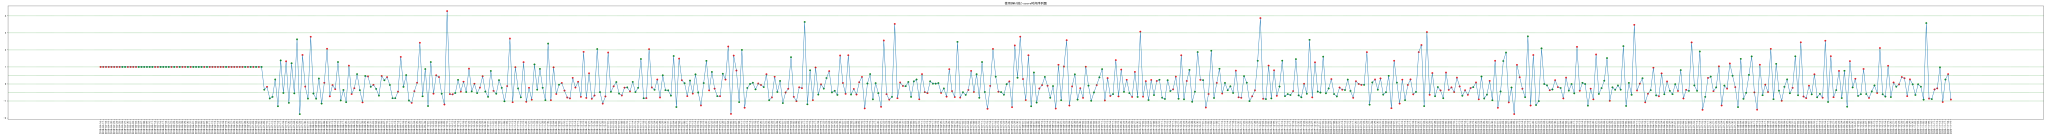

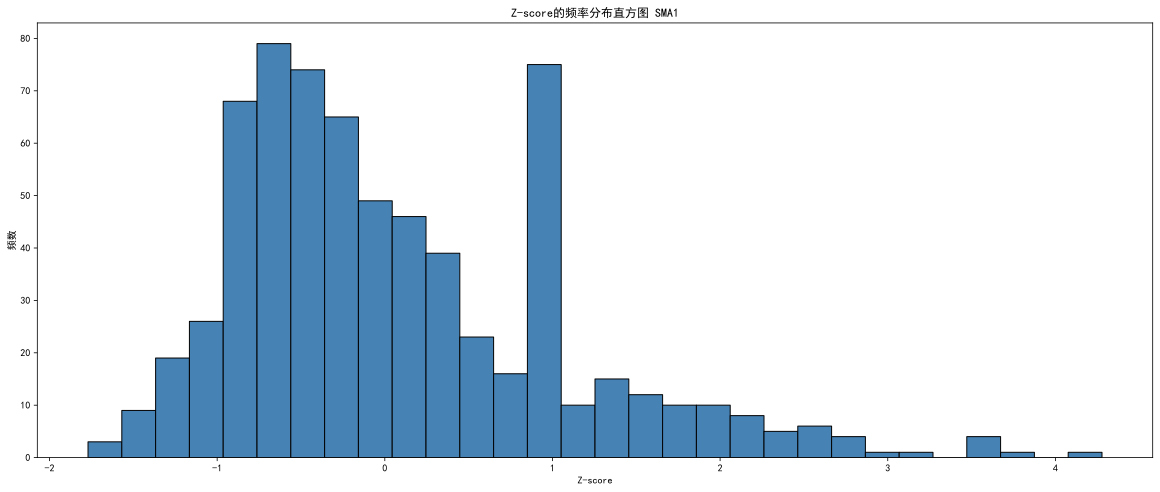

In [54]:
Pic4Zscore(test,1)

In [12]:
def forSMA1(df,T,a,b,num,sigma=0):#T表示滚动向前取值
    #a表示需要获取的开始index，b表示后一个index,num表示要获取第几个季度的，有时候出现交易日未满60天，需要人为寻找合适的a和b
    Ratio = [1]#先填充一个1
    
    for i in range(1,len(df.Range)):
        temp = df.Range[i]/df.Range[i - 1]
        Ratio.append(temp)
    df1 = df.copy()
    df1["Ratio"] = Ratio
    
    ratio_mean = [1]*60
    ratio_std = [1]*60
    zscore = [1]*60
    for i in range(60,len(Ratio)):#剔除前60个值计算
        ratio_mean_sub = np.array(Ratio[(i-T):(i+1)]).mean()
        ratio_std_sub = np.array(Ratio[(i-T):(i+1)]).std()
        zscore_sub = (Ratio[i] - ratio_mean_sub)/ratio_std_sub
        ratio_mean.append(ratio_mean_sub)
        ratio_std.append(ratio_std_sub)
        zscore.append(zscore_sub)    
    df1['Z-score'] = zscore 
    
    #添加一个flag列
    flag = [0]   
    for i in range(len(zscore)-1):
        if abs(df1.High[i + 1] - df1.Close[i]) >= abs(df1.Low[i + 1] - df1.Close[i]):
            flag_temp = 1
        else:
            flag_temp = 0
        flag.append(flag_temp)
    
    df1["flag"] = flag
    #return df1
    #print(df1)
    
    ######################################################################以上，所需数据处理完毕
    #根据所给index绘制ratio时间序列图
    plt.figure(figsize = (20,8))
    plt.plot(df1[a:b].Date,df1[a:b].Ratio)
    plt.title("使用SMA1的Ratio时间序列图")
    plt.savefig('./SMA1_ratio_2020_{}_{}.jpg'.format(num,T))
    
    
    #根据所给index绘制zscore时间序列图
    plt.figure(figsize = (140,8))#################
    plt.plot(df1.Date[a:b],df1["Z-score"][a:b])
    plt.xticks(rotation=90)  
    plt.axhline(y=-1,ls=":",c="green")#添加水平直线
    plt.axhline(y=-0.5,ls=":",c="green")#添加水平直线
    plt.axhline(y=0,ls=":",c="green")#添加水平直线
    plt.axhline(y=0.5,ls=":",c="green")#添加水平直线
    plt.axhline(y=1,ls=":",c="green")#添加水平直线
    plt.axhline(y=2,ls=":",c="green")#添加水平直线
    plt.axhline(y=3,ls=":",c="green")#添加水平直线
    plt.axhline(y=4,ls=":",c="green")#添加水平直线
    
    plt.scatter(df1[a:b].loc[df1["flag"] == 1].Date,df1[a:b].loc[df1["flag"] == 1]["Z-score"],color = 'green',label = 'up')
    plt.scatter(df1[a:b].loc[df1["flag"] == 0].Date,df1[a:b].loc[df1["flag"] == 0]["Z-score"],color = 'red',label = 'down')
    
    plt.title("使用SMA1的Z-score时间序列图")
    #plt.savefig('./SMA1_zscore_2020_{}_{}.jpg'.format(num,T))
    
    plt.figure(figsize = (20,8))
    plt.hist(x=df1["Ratio"][a:b],bins=30,color="steelblue",edgecolor="black")
    plt.xlabel("Ratio")
    plt.ylabel("频数")
    plt.title("Ratio的频率分布直方图 未剔除异常值 SMA1")
    
    
    #处理sigma
    counts1, bin_edges1 = np.histogram(zscore[60:], bins=100)#注意zscore的前几个数是有问题的，切片时注意
    low1, high1 = CalcTargetBoundary(counts1, bin_edges1, 0.6826)[0],CalcTargetBoundary(counts1, bin_edges1, 0.6826)[1]#一倍标准差的范围
    low2, high2 = CalcTargetBoundary(counts1, bin_edges1, 0.9545)[0],CalcTargetBoundary(counts1, bin_edges1, 0.9545)[1]
    del_outlier1 = [i if (i >= low1) & (i <= high1) else 8 for i in zscore]
    del_outlier2 = [i if (i >= low2) & (i <= high2) else 8 for i in zscore]
    #df1["del_outlier1"] = del_outlier1
    #print(len(del_outlier1))
    #绘制去掉sigma的所给index的时间序列图
    if sigma != 0:#sigma不为0的时候执行，也就是需要剔除标准差之外的来作图
        plt.figure(figsize = ((100,8)))#########################
        if sigma == 1:
            plt.plot(df1.Date[a:b],del_outlier1[a:b])
            plt.xticks(rotation=90)
            plt.title("SMA1标出了一倍标准差的Z-score时间序列图")
        else:
            plt.plot(df1.Date[a:b],del_outlier2[a:b])
            plt.xticks(rotation=90)
            plt.title("SMA1标出了两倍标准差的Z-score时间序列图")
        plt.xlabel("time")
        plt.ylabel("zscore")
        #plt.savefig('./sigma_{}_SMA1_2020_{}_{}.jpg'.format(sigma,num,T))
        
    #根据所给index绘制zscore频率分布直方图
    plt.figure(figsize = (20,8))
    plt.rcParams["font.sans-serif"]='SimHei'
    plt.rcParams['axes.unicode_minus']=False
    %config InlineBackend.figure_format='svg'

    plt.hist(x=df1["Z-score"][a:b],bins=30,color="steelblue",edgecolor="black")
    plt.xlabel("Z-score")
    plt.ylabel("频数")
    plt.title("Z-score的频率分布直方图 SMA1")
    #plt.savefig('./SMA1_2020_{}_frequency_hist_{}.jpg'.format(num,T))
     
    #绘制去掉sigma的频率分布直方图
    if sigma != 0:
        plt.figure(figsize = (20,8))
        plt.rcParams["font.sans-serif"]='SimHei'
        plt.rcParams['axes.unicode_minus']=False
        %config InlineBackend.figure_format='svg'
        if sigma == 1:
            plt.hist(x=del_outlier1,bins=30,color="steelblue",edgecolor="black")
            plt.xticks(rotation=90)
            plt.title("SMA1剔除一倍标准差的Z-score频率分布直方图")
        else:
            plt.hist(x=del_outlier2,bins=30,color="steelblue",edgecolor="black")
            plt.xticks(rotation=90)
            plt.title("SMA1剔除两倍标准差的Z-score频率分布直方图")
        
        plt.xlabel("Z-score")
        plt.ylabel("频数")
        #plt.savefig('./sigma_{}_SMA1_2020_{}_frequency_hist_{}.jpg'.format(sigma,num,T))

D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29992 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 38388 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24207 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-package

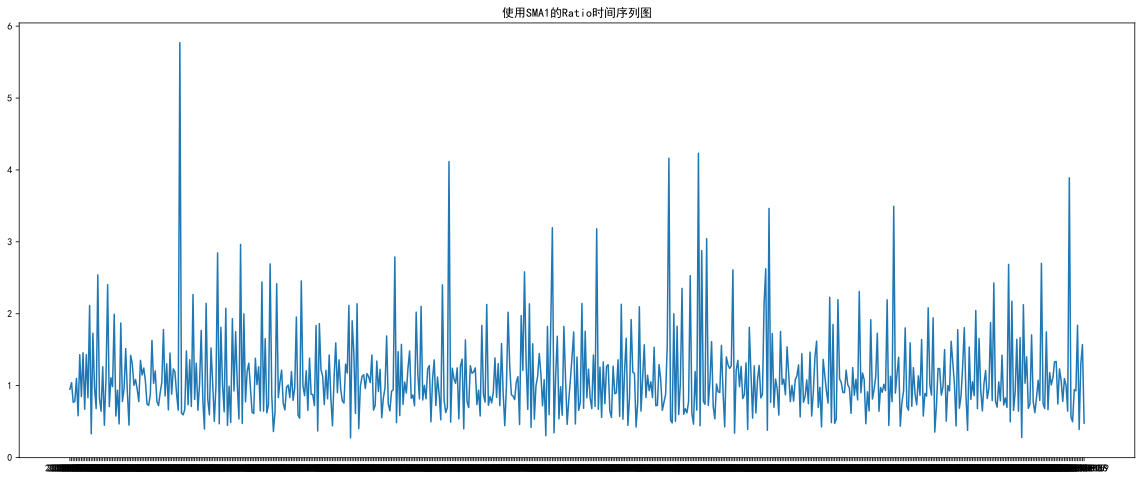

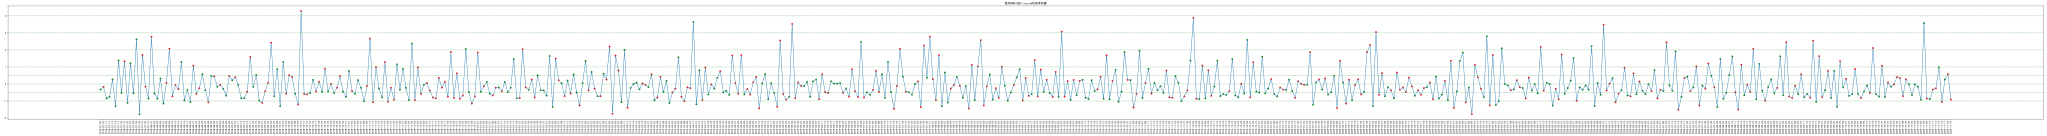

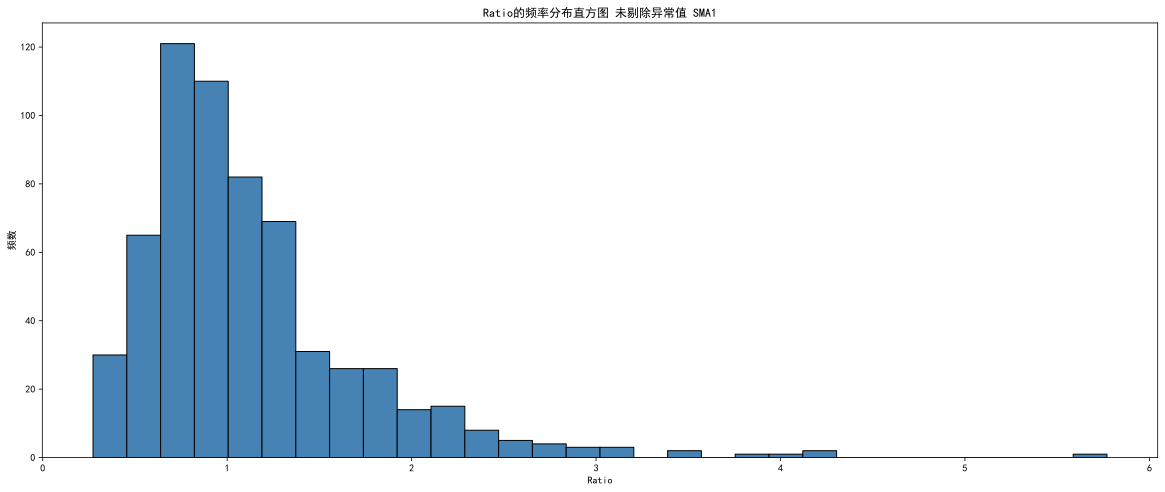

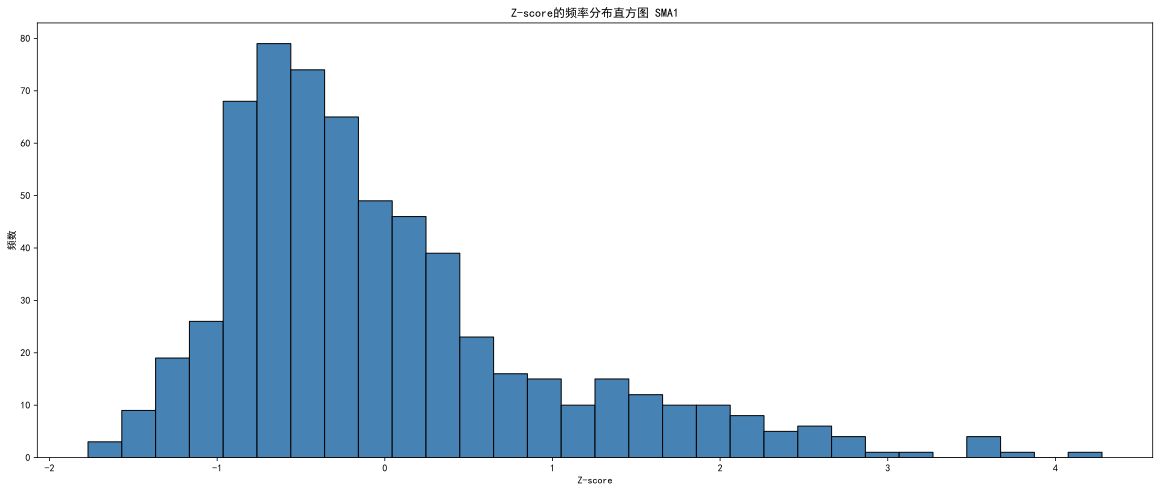

In [13]:
forSMA1(df,20,60,len(df),1,sigma=0)

In [ ]:
def forSMA1remove(df,T,a,b,num):#T表示滚动向前取值     #######!!!!!!!!!二次zscore有点问题    应该输入的是ratio而不是zscore
    #a表示需要获取的开始index，b表示后一个index,num表示要获取第几个季度的，有时候出现交易日未满60天，需要人为寻找合适的a和b
    Ratio = [1]#先填充一个1
    for i in range(1,len(df.Range)):
        temp = df.Range[i]/df.Range[i - 1]
        Ratio.append(temp)
    df1 = df.copy()
    df1["Ratio"] = Ratio
    
    ratio_mean = [1]*60
    ratio_std = [1]*60
    zscore = [1]*60
    for i in range(60,len(Ratio)):#剔除前60个值计算
        ratio_mean_sub = np.array(Ratio[(i-T):(i+1)]).mean()
        ratio_std_sub = np.array(Ratio[(i-T):(i+1)]).std()
        zscore_sub = (Ratio[i] - ratio_mean_sub)/ratio_std_sub
        ratio_mean.append(ratio_mean_sub)
        ratio_std.append(ratio_std_sub)
        zscore.append(zscore_sub)    
    df1['Z-score'] = zscore
    
    ##添加一个flag列
    #flag = [0]   
    #for i in range(len(zscore)-1):
    #    if abs(df1.High[i + 1] - df1.Close[i]) >= abs(df1.Low[i + 1] - df1.Close[i]):
    #        flag_temp = 1
    #    else:
    #        flag_temp = 0
    #    flag.append(flag_temp)
    #
    #df1["flag"] = flag
    #print(df1)
    
    ######################################################################以上，所需数据处理完毕
    #处理ratio的异常值,因为不存在时间作为横坐标的问题，比zscore好处理多了
    counts, bin_edges = np.histogram(Ratio[60:], bins=100)#注意zscore的前几个数是有问题的，切片时注意
    low, high = CalcTargetBoundary(counts, bin_edges, 0.6826)[0],CalcTargetBoundary(counts, bin_edges, 0.6826)[1]#一倍标准差的范围
    del_outlier = [i for i in Ratio[a:b] if (i >= low) & (i <= high)]
    
    ##Ratio的时间序列图
    #plt.figure(figsize = (20,8))
    #plt.plot(del_outlier)
    #plt.title("使用SMA1的Ratio 剔除异常值 时间序列图")
    ##plt.savefig('./SMA1_ratio_timeseries_del_2020_{}_{}.jpg'.format(num,T))
    
    
    #根据给定index画Ratio的频率分布直方图
    plt.figure(figsize = (20,8))
    plt.rcParams["font.sans-serif"]='SimHei'
    plt.rcParams['axes.unicode_minus']=False
    %config InlineBackend.figure_format='svg'

    plt.hist(x=del_outlier,bins=30,color="steelblue",edgecolor="black")
    plt.xlabel("Ratio")
    plt.ylabel("频数")
    plt.title("Ratio的频率分布直方图 剔除异常值 SMA1")
    plt.savefig('./SMA1_all_Ratio_frequency_hist_del_{}_{}.jpg'.format(T,num))
    
    
    
    
    ##处理zscore的异常值
    counts1, bin_edges1 = np.histogram(zscore[60:], bins=100)#注意zscore的前几个数是有问题的，切片时注意
    low1, high1 = CalcTargetBoundary(counts1, bin_edges1, 0.6826)[0],CalcTargetBoundary(counts1, bin_edges1, 0.6826)[1]#一倍标准差的范围
    #low2, high2 = CalcTargetBoundary(counts1, bin_edges1, 0.9545)[0],CalcTargetBoundary(counts1, bin_edges1, 0.9545)[1]
    #del_outlier1 = [i for i in zscore if (i >= low1) & (i <= high1)]
    #del_outlier2 = [i for i in zscore if (i >= low2) & (i <= high2)]
    
    df_scatter = df1[a:b].loc[(df1["Z-score"]>= low1)&(df1["Z-score"]<= high1)].reset_index(drop = True)
    
    
    zscore1 = []
    for i in range(60,len(df_scatter)):#怕T取60的时候下面index超出范围
        ratio_mean_sub = np.array(df_scatter["Z-score"][(i-T):(i+1)]).mean()
        ratio_std_sub = np.array(df_scatter["Z-score"][(i-T):(i+1)]).std()
        zscore1_sub = (df_scatter["Z-score"][i] - ratio_mean_sub)/ratio_std_sub
        ratio_mean.append(ratio_mean_sub)
        ratio_std.append(ratio_std_sub)
        zscore1.append(zscore1_sub)
        
    plt.figure(figsize = (100,8))#################
    plt.plot(df_scatter.Date,df_scatter["Z-score"])
    
    plt.scatter(df_scatter.loc[df1["flag"] == 1].Date,df_scatter.loc[df1["flag"] == 1]["Z-score"],color = 'green',label = 'up')
    plt.scatter(df_scatter.loc[df1["flag"] == 0].Date,df_scatter.loc[df1["flag"] == 0]["Z-score"],color = 'red',label = 'down')
    
    plt.axhline(y=-1.5,ls=":",c="green")#添加水平直线
    plt.axhline(y=-1,ls=":",c="green")#添加水平直线
    plt.axhline(y=-0.5,ls=":",c="green")#添加水平直线
    plt.axhline(y=0,ls=":",c="green")#添加水平直线
    plt.axhline(y=0.5,ls=":",c="green")#添加水平直线
    plt.axhline(y=1,ls=":",c="green")#添加水平直线
    plt.xticks(rotation=90)
    
    plt.title("使用SMA1的剔除一倍标准差的Z-score时间序列图")
    #plt.savefig('./SMA1_all_timeseries_{}.jpg'.format(T))
    
    #根据所给index绘制zscore的频率分布直方图
    plt.figure(figsize = (20,8))
    plt.rcParams["font.sans-serif"]='SimHei'
    plt.rcParams['axes.unicode_minus']=False
    %config InlineBackend.figure_format='svg'
    plt.hist(x=zscore1,bins=30,color="steelblue",edgecolor="black")
    plt.xlabel("Z-score")
    plt.ylabel("频数")
    plt.title("Z-score的频率分布直方图 SMA1")
    #plt.savefig('./SMA1_all_Zscore_frequency_hist_{}.jpg'.format(T))

In [ ]:
forSMA1remove(df,20,753,813,5)